In [3]:
# check env
import os
import torch
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

print("PyTorch version: %s" % torch.__version__)

if not torch.cuda.is_available():
    print("Running on CPU")
else:
    print("Runing on GPU %s" % torch.cuda.get_device_name())

PyTorch version: 2.0.1+cu118
Runing on GPU NVIDIA GeForce RTX 3090


In [4]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 8E28-94E5

 Directory of c:\Users\CanonUser\OneDrive - CanonUSA365\Documents\GitHub\pcd_generation\depth_map\unimatch

11/14/2024  04:32 PM    <DIR>          .
08/26/2024  02:04 PM    <DIR>          ..
08/26/2024  02:11 PM    <DIR>          .git
10/21/2024  12:53 PM    <DIR>          __pycache__
10/24/2024  04:18 PM        11,645,363 Camera_1_flo.ply
08/13/2024  02:27 PM             2,922 conda_environment.yml
08/26/2024  02:11 PM    <DIR>          dataloader
08/13/2024  02:27 PM             3,372 DATASETS.md
10/21/2024  12:34 PM    <DIR>          demo
11/07/2024  11:49 AM         1,061,088 depth_flow.ipynb
11/14/2024  10:41 AM            58,791 depth_flow_karate.ipynb
10/24/2024  04:25 PM         3,497,679 depth_from_flo.mp4
11/14/2024  04:32 PM           188,901 depth_gen.ipynb
08/13/2024  02:27 PM            16,265 evaluate_depth.py
08/13/2024  02:27 PM            32,673 evaluate_flow.py
08/20/2024  01:06 PM            31,949

## 1. Generate depth from optic flow

In [ ]:
#load, resize and save images
import cv2
import os 
import glob

basedir = "demo/"
inputdir = basedir + "input/flow/karate/"
files = glob.glob(inputdir + '*.png')
for file in files:
    img = cv2.imread(file)
    img_w, img_h = img.shape[1], img.shape[0]
    img = cv2.resize(img, (int(img_w/4), int(img_h/4)))
    fname = os.path.basename(file).split('.')[0]
    print(fname)
    cv2.imwrite(inputdir+fname+'_resized.png', img)

In [ ]:
!python main_flow.py \
--inference_dir demo/input/flow/karate \
--output_path demo/output/flow/karate \
--padding_factor 32 \
--save_flo_flow \
--upsample_factor 4 \
--num_scales 2 \
--attn_splits_list 2 8 \
--corr_radius_list -1 4 \
--prop_radius_list -1 1 \
--reg_refine \
--num_reg_refine 6 \
--resume pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth \


#--resume pretrained/gmflow-scale2-mixdata-train320x576-9ff1c094.pth

#--resume pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth \
#--inference_size 1024 1822 \

In [5]:
import numpy as np
import cv2
# load flow map
flow_rpg = cv2.imread('demo/output/flow/karate/frame_007_resized_flow.png', cv2.IMREAD_UNCHANGED)
img_ori = cv2.imread('demo/input/flow/karate/orig/frame_009.png')
img_h, img_w = img_ori.shape[0], img_ori.shape[1]

def read_flo_file(filename, resize = None):
    with open(filename, 'rb') as f:
        # Read the header
        magic = np.fromfile(f, np.float32, count=1)[0]
        if magic != 202021.25:
            raise ValueError('Magic number incorrect. Invalid .flo file')
        
        # Read the width and height
        width = np.fromfile(f, np.int32, count=1)[0]
        height = np.fromfile(f, np.int32, count=1)[0]
        
        # Read the flow data
        data = np.fromfile(f, np.float32, count=2*width*height)
        flow = np.resize(data, (height, width, 2))

    if resize is not None:
         # Resize the flow to the original image size
        flow_resized = cv2.resize(flow, (resize[1], resize[0]), interpolation=cv2.INTER_LINEAR)
        flow_resized[:, :, 0] *= resize[1] / width
        flow_resized[:, :, 1] *= resize[0] / height
        return flow_resized

        
    return flow

# Example usage
flow = read_flo_file('demo/output/flow/karate/frame_007_resized_pred.flo', (img_h, img_w))
print(flow, flow.shape)

[[[ 296.65192   247.38379 ]
  [ 296.65192   247.38379 ]
  [ 296.6863    247.34909 ]
  ...
  [-103.83649   279.77972 ]
  [-103.831345  279.78577 ]
  [-103.831345  279.78577 ]]

 [[ 296.65192   247.38379 ]
  [ 296.65192   247.38379 ]
  [ 296.6863    247.34909 ]
  ...
  [-103.83649   279.77972 ]
  [-103.831345  279.78577 ]
  [-103.831345  279.78577 ]]

 [[ 296.65677   247.43147 ]
  [ 296.65677   247.43147 ]
  [ 296.68988   247.39445 ]
  ...
  [-103.838585  279.78207 ]
  [-103.833984  279.78296 ]
  [-103.833984  279.78296 ]]

 ...

 [[ 304.5165    155.461   ]
  [ 304.5165    155.461   ]
  [ 304.50284   155.32898 ]
  ...
  [ -90.64926    28.263048]
  [ -90.60945    28.205301]
  [ -90.60945    28.205301]]

 [[ 304.55585   155.71954 ]
  [ 304.55585   155.71954 ]
  [ 304.5409    155.57628 ]
  ...
  [ -90.617134   28.215998]
  [ -90.573746   28.151707]
  [ -90.573746   28.151707]]

 [[ 304.55585   155.71954 ]
  [ 304.55585   155.71954 ]
  [ 304.5409    155.57628 ]
  ...
  [ -90.617134   28.2159

In [13]:
# read camera parameters specially for the karate dataset
import glob
import sys
import os
import numpy as np
import json

camerafile = "demo/input/flow/karate/transforms.json"
basedir = 'demo/'
outputdir = basedir + "output/flow/karate/"
outputfiles = glob.glob(outputdir + '*.flo')
inputdir = basedir + "input/flow/karate/"
inputfiles = glob.glob(inputdir + '*.png')
cams = {}

with open(camerafile) as f:
    cam_data = json.load(f)

for file in inputfiles:
    fname = os.path.basename(file)
    cam_id = int(fname.split('_')[1])
    cams[f'{cam_id:03}'] = cam_data['frames'][cam_id]

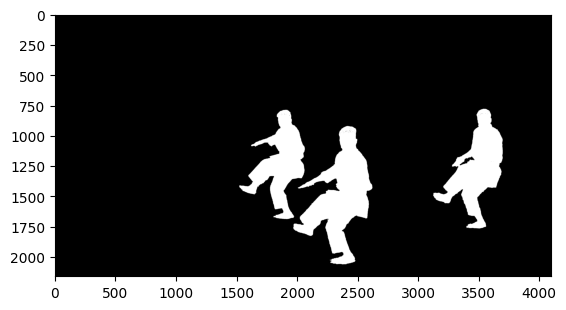

In [7]:
#now create mask for karate dataset, only need to do this once
import matplotlib.pyplot as plt
import sys
parent_dir = os.path.join(os.getcwd(), '..\\..\\')
sys.path.append(parent_dir)
from utils.mask_processing import binarize_mask
mask = np.zeros((img_h, img_w))
mask[img_ori[:,:,0] != 0] = 1
binary_mask = binarize_mask(mask, threshold=0.5)
plt.imshow(binary_mask, cmap='gray')

In [8]:
# Obtain correspondance points
def get_new_locations(first_frame, flow, mask=None):
    """
    Get the new locations of the first frame pixels in the second frame using the optical flow map.
    
    Args:
        first_frame: The first image frame (HxW or HxWxC).
        flow: The optical flow map (HxWx2).
    
    Returns:
        new_locations: The new locations of the first frame pixels in the second frame (HxWx2).
    """
    height, width = first_frame.shape[:2]
    
    # Create a grid of coordinates in the first frame
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    
    # Extract the flow vectors
    u = flow[:, :, 0]
    v = flow[:, :, 1]
    
    # Compute the new locations
    new_x = x + u
    new_y = y + v

    if mask is not None:
        new_x = new_x[mask > 0]
        new_y = new_y[mask > 0]
        x = x[mask > 0]
        y = y[mask > 0]

    print(x.shape, y.shape)
    
    # Stack the new coordinates
    original_locations = np.stack((x, y), axis=-1)
    new_locations = np.stack((new_x, new_y), axis=-1)
    
    return original_locations, new_locations

In [9]:
points1, points2 = get_new_locations(img_ori, flow, binary_mask)

(739744,) (739744,)


In [2]:
import csv
from collections import namedtuple
def get_all_rows_from_csv_as_numpy_float(csv_file, num_cols):
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        rows = [row for row in reader]
    rows = np.array(rows)[:,:num_cols].astype(np.float32)
    return rows

def get_cam_params_from_csv(input_dir):
    cam_params = []
    extrinsicts_file = os.path.join(input_dir, "camera_extrinsic.csv")
    instrinsics_file = os.path.join(input_dir, "camera_intrinsic.csv")
    distortion_file = os.path.join(input_dir, "camera_distortion.csv")
    #info_list_file = os.path.join(input_dir, "info_list.csv")

    extrinsics = get_all_rows_from_csv_as_numpy_float(extrinsicts_file, 9)
    instrinsics = get_all_rows_from_csv_as_numpy_float(instrinsics_file, 5)
    distortion = get_all_rows_from_csv_as_numpy_float(distortion_file, 8)
    #caminfo = get_all_rows_from_csv_as_numpy_float(info_list_file, 3)
    for i in range(len(extrinsics)):
        camParams = namedtuple('camParams', 'inParam, exParam, diParam')
        cam_params.append(camParams(inParam=instrinsics[i], exParam=extrinsics[i], diParam=distortion[i]))
    return cam_params

cam_params = get_cam_params_from_csv("demo/input/flow/karate/camParam")

NameError: name 'os' is not defined

In [56]:
def reorder_cam_params(cam_params, cam_param_dir):
    csv_file = os.path.join(cam_param_dir, "info_list.csv")
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        rows = [row for row in reader]
    new_cam_params = [None] * len(cam_params)
    for i in range(len(rows)):
        index = int(rows[i][1]) - 1
        new_cam_params[index] = cam_params[i]
    return new_cam_params

cam_params = reorder_cam_params(cam_params, "demo/input/flow/karate/camParam")

In [58]:
cam_params[9]

camParams(inParam=array([5250.846 ,    0.    , 2076.9705, 5250.846 , 1100.7212],
      dtype=float32), exParam=array([ 6.8660663e+02, -7.2562896e+03,  2.0064969e+03, -2.4783704e-01,
        9.6362507e-01, -1.0001763e-01,  2.7211824e-02, -9.6273676e-02,
       -9.9498284e-01], dtype=float32), diParam=array([ 0.04980123,  0.5958331 ,  0.        ,  0.        , -0.06726232,
        0.        ,  0.        ,  0.        ], dtype=float32))

In [59]:
cam_params[7]

camParams(inParam=array([4879.9536,    0.    , 2085.6848, 4879.9536, 1083.6731],
      dtype=float32), exParam=array([-1.2012361e+03, -7.2568833e+03,  3.8057927e+03, -7.6552846e-02,
        9.6619231e-01, -2.4619518e-01,  2.1081708e-02, -2.4529606e-01,
       -9.6921897e-01], dtype=float32), diParam=array([0.03011837, 0.42750165, 0.        , 0.        , 0.16919899,
       0.        , 0.        , 0.        ], dtype=float32))

In [82]:
np.cross(cam_params[7][1][3:6], cam_params[7][1][6:9])

array([-0.9968426 , -0.07938669, -0.00159087], dtype=float32)

In [63]:
cam_params[35]

camParams(inParam=array([2210.6072,    0.    , 2054.1912, 2210.6072, 1093.7312],
      dtype=float32), exParam=array([-1.69366614e+03,  3.88128632e+02,  4.21887695e+03,  3.93329918e-01,
       -8.79666284e-02, -9.15179431e-01, -9.19163108e-01, -1.51526695e-02,
       -3.93585563e-01], dtype=float32), diParam=array([-0.02085082,  0.01444887,  0.        ,  0.        , -0.00547272,
        0.        ,  0.        ,  0.        ], dtype=float32))

In [68]:
cam_params[18]

camParams(inParam=array([3752.1562,    0.    , 2074.731 , 3752.1562, 1091.8737],
      dtype=float32), exParam=array([-1.4472284e+03, -7.2361201e+03,  3.7558909e+03, -8.5398341e-03,
        8.7388080e-01, -4.8606518e-01, -9.9996299e-01, -6.9424687e-03,
        5.0870287e-03], dtype=float32), diParam=array([-0.08688781,  0.37379116,  0.        ,  0.        , -0.21343455,
        0.        ,  0.        ,  0.        ], dtype=float32))

In [ ]:
def calcExtrinsicVecs(exParam):
    t = exParam[:3]  # Translation vector
    d = exParam[3:6]  # Direction vector
    a = exParam[6:]  # Axis vector, axis vector is the y direction of the image plane pointing down

    # Normalize the axis vector to get the y-axis (ry)
    ry = np.reshape(a / np.linalg.norm(a), (3)) # y axis is the direction the camera is facing
    
    # Normalize the direction vector to get the z-axis (rz)
    rz = np.reshape(d / np.linalg.norm(d), (3))
    
    # Compute the cross product of ry and rz to get the x-axis (rx), x axis is the rightward direction of the image plane
    rx = np.reshape(np.cross(ry, rz), (3))
    rx = rx / np.linalg.norm(rx)  # Normalize rx

    
    # Construct the rotation matrix R. Need to negate rx.
    R = np.array([rx, rz, ry]).T

    # Create a named tuple to store R and t
    exVecs = namedtuple("exVecs", "R, t")
    return exVecs(R=R, t=t)

In [116]:
R, t = calcExtrinsicVecs(cam_params[7][1])
x = t[0]; y = t[2]; z = t[1]; # camera position in world coordinate; Values are swapped to match the world coordinate system. see notes above
RT = np.eye(4)
RT[:3, :3] = R
#rotation_matrix = RT.copy()

T = np.array([x, y, z])# 
RT[:3, 3] = -R @ T

RT

array([[ 9.96842623e-01, -7.65528455e-02,  2.10817084e-02,
         1.64177515e+03],
       [ 7.93866888e-02,  9.66192305e-01, -2.45296061e-01,
        -5.36185059e+03],
       [ 1.59087218e-03, -2.46195182e-01, -9.69218969e-01,
        -6.09462988e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [117]:
f = cam_params[7][0][0]
cx, cy = cam_params[7][0][2], cam_params[7][0][4]
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])  
P1 = K @ RT

In [118]:
R, t = calcExtrinsicVecs(cam_params[9][1])
x = t[0]; y = t[2]; z = t[1]; # camera position in world coordinate; Values are swapped to match the world coordinate system. see notes above
RT = np.eye(4)
RT[:3, :3] = R
#rotation_matrix = RT.copy()

T = np.array([x, y, z])# 
RT[:3, 3] = -R @ T

f = cam_params[9][0][0]
cx, cy = cam_params[9][0][2], cam_params[9][0][4]
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])  
P0 = K @ RT

In [43]:
#get camera transformation based on camera parameters for karate dataset
M = np.array(cams['009']['transform_matrix'])
M[:3, 3] *=1e6
f = cams['009']['fl_x']
cx, cy = cams['009']['cx'], cams['009']['cy']
# Projection matrix P (3x4)
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])  
P0 = K @ M
print(M)

M = np.array(cams['007']['transform_matrix'])
M[:3, 3] *=  1e6
f = cams['007']['fl_x']
cx, cy = cams['007']['cx'], cams['007']['cy']
# Projection matrix P (3x4)
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])  
P1 = K @ M

[[ 9.68419552e-01 -2.72118263e-02  2.47837037e-01  6.86606625e+02]
 [ 2.49315277e-01  9.62736830e-02 -9.63625073e-01 -7.25628948e+03]
 [ 2.36181356e-03  9.94982898e-01  1.00017630e-01  2.00649700e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [44]:
M

array([[ 9.96842682e-01, -2.10817084e-02,  7.65528455e-02,
        -1.20123604e+03],
       [ 7.93866962e-02,  2.45296061e-01, -9.66192305e-01,
        -7.25688320e+03],
       [ 1.59087230e-03,  9.69218969e-01,  2.46195182e-01,
         3.80579266e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [110]:
def triangulate_point(P1, P2, point1, point2):
    """
    Triangulate a 3D point from two views.
    
    Args:
        P1: Projection matrix for the first camera (3x4).
        P2: Projection matrix for the second camera (3x4).
        point1: Homogeneous coordinates of the point in the first image (3x1).
        point2: Homogeneous coordinates of the point in the second image (3x1).
    
    Returns:
        X: Triangulated 3D point in homogeneous coordinates (4x1).
    """
    A = np.zeros((4, 4))
    A[0] = point1[0] * P1[2] - P1[0]
    A[1] = point1[1] * P1[2] - P1[1]
    A[2] = point2[0] * P2[2] - P2[0]
    A[3] = point2[1] * P2[2] - P2[1]
    
    _, _, V = np.linalg.svd(A)
    X = V[-1]
    X = X / X[3]
    return X

In [119]:
points1_h = np.concatenate((points1, np.ones((points1.shape[0], 1))), axis=1)
points2_h = np.concatenate((points2, np.ones((points2.shape[0], 1))), axis=1)
points1_h[:,1] = img_h - points1_h[:,1]
points2_h[:,1] = img_h - points2_h[:,1]
points2_h

array([[ 3.52926772e+03,  1.16966492e+03,  1.00000000e+00],
       [ 3.53015417e+03,  1.16917757e+03,  1.00000000e+00],
       [ 3.53102847e+03,  1.16882091e+03,  1.00000000e+00],
       ...,
       [ 2.60217577e+03, -8.43675537e+01,  1.00000000e+00],
       [ 2.60140721e+03, -8.31587219e+01,  1.00000000e+00],
       [ 2.60063867e+03, -8.19498749e+01,  1.00000000e+00]])

In [120]:
Xs = []
for i in range(0, points1_h.shape[0]):
    X = triangulate_point(P0, P1, points1_h[i], points2_h[i])
    Xs.append(X)

In [124]:
Xs = np.array(Xs)
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
colors = img_ori.copy()[binary_mask > 0]
colors.shape

(739744, 3)

In [ ]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Xs[:,:3])
pcd.colors = o3d.utility.Vector3dVector(colors/255.0)
o3d.io.write_point_cloud(f"frame_009_flo.ply", pcd)
#print(pcd)
o3d.visualization.draw_geometries([pcd])

: 